# The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2019 Semester 1
-----
## Project 1: Gaining Information about Naive Bayes
-----
###### Student Name(s): Akira and Callum
###### Python version: 3.7.1 from Anaconda 
###### Submission deadline: 1pm, Fri 5 Apr 2019

This iPython notebook is a template which you may use for your Project 1 submission. (You are not required to use it; in particular, there is no need to use iPython if you do not like it.)

Marking will be applied on the five functions that are defined in this notebook, and to your responses to the questions at the end of this notebook.

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find. 

**The cell below supresses forced output scrolling so you can see view the script output easier**

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**We have specifically imported all functions below to ensure we implemented iteratively AND without the use of external functions wherever possible**

In [2]:
from pandas import read_csv, DataFrame, Series
from collections import defaultdict
from numpy import NaN
from math import log

########## POSSIBLE CSVs ##########
d1 =  'anneal.csv'
h1 = 'family,product-type,steel,carbon,hardness,temper_rolling,condition,formability,strength,non-ageing,surface-finish,surface-quality,enamelability,bc,bf,bt,bw-me,bl,m,chrom,phos,cbond,marvi,exptl,ferro,corr,bbvc,lustre,jurofm,s,p,shape,oil,bore,packing,class'.split(',')

d2 =  'breast-cancer.csv'
h2 = 'age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,class'.split(',')

d3 =  'car.csv'
h3 = 'buying,maint,doors,persons,lug_boot,safety,class'.split(',')

d4 =  'cmc.csv'
h4 = 'w-education,h-education,n-child,w-relation,w-work,h-occupation,standard-of-living,media-exposure,class'.split(',')

d5 =  'hepatitis.csv'
h5 = 'sex,steroid,antivirals,fatigue,malaise,anorexia,liver-big,liver-firm,spleen-palpable,spiders,ascites,varices,histology,class'.split(',')

d6 =  'hypothyroid.csv'
h6 = 'sex,on-thyroxine,query-on-thyroxine,on_antithyroid,surgery,query-hypothyroid,query-hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH,T3,TT4,T4U,FTI,TBG,class'.split(',')

d7 =  'mushroom.csv'
h7 = 'cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class'.split(',')

d8 =  'nursery.csv'
h8 = 'parents,has_nurs,form,children,housing,finance,social,health,class'.split(',')

d9 = 'primary-tumor.csv'
h9 = 'age,sex,histologic-type,degree-of-diffe,bone,bone-marrow,lung,pleura,peritoneum,liver,brain,skin,neck,supraclavicular,axillar,mediastinum,abdominal,class'.split(',')

datasets = [d1,d2,d3,d4,d5,d6,d7,d8,d9]
dataset_headers = [h1,h2,h3,h4,h5,h6,h7,h8,h9]

dictionary = {datasets[i] : dataset_headers[i] for i in range(len(datasets))}

"""Sets the column of each dataset"""
def set_column(filename):
    return dictionary[filename]

In [20]:
"""Has been adjusted so that it works with testing on the train data, and partitioning for cross_val"""
def preprocess(filename, testing_on_train = True, k = 10, drop = 'no', impute = 'no'):
    # Add column headers, drop columns with only one unique value (all same value)
    df = read_csv(filename, header = None, names = set_column(filename))
    df.replace('?', NaN, inplace=True)
    
    #### ONLY USED FOR QUESTION 6 - NOT FOR FUNCTIONALITY ####
    if impute in 'yesYesYES':    
        print(f"Number of missing values: {df.isna().sum().sum()}")
        mode = df.mode().iloc[0]
        for col in df.columns[:-1]:
            mode = df[col].mode()
            df[col].fillna(mode)
    ##########################################################
    
    """If we are not using the cross validation method"""
    # Return the whole dataset as a dataframe
    if testing_on_train:
        return df
    else:
        """Drop no gain attributes given the input in the script"""
        if drop in 'yesYesYES':
            non_unique = df.apply(Series.nunique)
            df.drop(non_unique[non_unique == 1].index, axis=1, inplace=True)
            
        temp = df.copy()
        partitions = list()
        
        # k-fold Cross Validation
        divisor = k
        
        for i in range(k):
            partitions.append(temp.sample(frac=1/divisor))
            divisor -= 1
            temp.drop(partitions[-1].index, axis=0, inplace=True)
        
        del temp
        
        # Dictionary of train/test pairs
        cross_validation_pairs = defaultdict(list)
        models = list()
        
        for i in range(k):
            test = partitions[i]
            train = df.iloc[df.index.drop(test.index.values)]
            cross_validation_pairs["train"].append(train)
            cross_validation_pairs["test"].append(test)
            
        return cross_validation_pairs

In [4]:
"""Trains a model given a training dataset"""
def train(train_set):
    N = len(train_set)
    priors = {}
    posteriors = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
    """Accessable using posteriors[class j][attribute x][value i]"""
    
    for label in train_set['class'].unique():
        priors[label] = len(train_set.loc[train_set['class'] == label]) / N
        for attribute in train_set.columns[:-1]:
            temp = train_set.loc[train_set['class'] == label, [attribute,'class']]
            n = len(temp)
            
            count = defaultdict(int)
            for i in temp[attribute]:
                if i != NaN:
                    count[i] += 1
            
            for i in count:
                posteriors[label][attribute][i] = count[i] / n
                
    trained_model = {"priors": priors, "posteriors": posteriors}
    
    return trained_model

"""Trains M partitions for cross_val"""
def cross_validation_train(cross_validation_pairs):
    trained_models = list()
    train_set = cross_validation_pairs["train"]
    test_set = cross_validation_pairs["test"]
    N = len(train_set)
    
    for i in range(N):
        trained_models.append(train(train_set[i]))
        
    return trained_models

In [5]:
"""Predicts a test set"""
def predict(trained_model, test_set):
    priors = trained_model["priors"]
    posteriors = trained_model["posteriors"]
    
    """Drop the class labels of the test set"""
    test_labels = test_set['class']
    test = test_set.drop('class', axis=1)
    cols = test_set.columns
    
    """Probabilistic Smoothing with epsilon -> 0"""
    n = len(test_labels)
    epsilon = 1e-100
    
    """Model Prediction"""
    prediction = {}
    
    """The Predicted Labels to be Returned"""
    """(Key, Value) = (Test Instance Row, Predicted Label)"""
    predicted_labels = {}
    
    for i in range(n):
        instance = test.iloc[i]
        for label in priors.keys():       
            prob = log(priors[label])/log(2)
            for attribute in cols:
                try:
                    """If the value is non missing"""
                    if instance[attribute] != NaN:
                        prob += log(posteriors[label][attribute][instance[attribute]])/log(2)
                    else:
                        """Otherwise we have chosen to simply ignore it"""
                        pass
                except:
                    """If the value does not exist in our model, we use epsilon"""
                    prob += log(epsilon)/log(2)
                    
            prediction[label] = prob
        
        """Choose the predicted class with the highest probability"""
        predicted_labels[i] = max(prediction, key=prediction.get)
        
    return predicted_labels

"""Tests partitions"""
def cross_validation_predict(trained_models, cross_validation_pairs):
    test_set = cross_validation_pairs["test"]
    N = len(test_set)
    predictions = list()
    
    for i in range(N):
        predictions.append(predict(trained_models[i], test_set[i]))
    
    return predictions

In [6]:
"""Evaluates the accuracy"""
def evaluate(predicted_labels, test_set):
    test_labels = test_set['class']
    n = len(test_labels)
    
    return [1 if predicted_labels[i] == test_labels.iloc[i] else 0 for i in range(n)]

"""Evaluates cross_val accuracy"""
def cross_validation_evaluate(predictions, cross_pairs):
    test = cross_pairs["test"]
    N = len(test)
    results = list()
    for i in range(N):
        results.append(evaluate(predictions[i], test[i]))
        
    return results

In [7]:
"""Calculates the entropy given a series"""
def entropy(distribution):
    # Calculates the entropy (uncertainty) of an event (class) for a given distribution 
    # (e.g. distribution given a certain attribute value)
    N = len(distribution)
    # Normalise and count values iteratively
    count = defaultdict(int)
    for i in distribution:
        count[i] += 1
    event = [i/N for i in count.values()]
    
    return (-1*sum([i*log(i)/log(2) for i in event]))

"""Calculates the mean information given a dataset"""
def mean_info(dataset):
    mean_info_per_attribute = defaultdict(float)
    
    for attribute in dataset.columns[:-1]:
        # Used to calculate 'probability' of said value for a random instance (number of values / total number of instances)
        
        attribute_value_counts = defaultdict(int)
        for i in dataset[attribute]:
            attribute_value_counts[i] += 1
            
        N = len(dataset[attribute])
        for value in dataset[attribute].unique():
            # dataframe.loc on said value and return the corresponding class column
            corresponding_values = dataset.loc[dataset[attribute] == value, 'class']
            # add (probability of said value * entropy of said value) to the attribute's mean info
            mean_info_per_attribute[attribute] += attribute_value_counts[value]/N * entropy(corresponding_values)
            
    return mean_info_per_attribute

"""Calculates the information gain given a dataset. Adjusted so that it can drop 0 info_gain columns"""
def info_gain(dataset, drop_no_gain = False):
    mean_info_per_attribute = mean_info(dataset) # Weighted sum of child stump entropies if split on each attribute
    class_entropy = entropy(dataset['class']) # H(R), the entropy of class distribution prior to splitting
    info_gain_given_class = defaultdict(float)
    
    for attribute in mean_info_per_attribute:
        # Calculates IG(attribute) for the dataset's class
        info_gain_given_class[attribute] = class_entropy - mean_info_per_attribute[attribute]
    
    """If we want to drop the columns with absolutely 0 information gain"""
    if drop_no_gain:
        non_unique = dataset.apply(Series.nunique)
        dataset.drop(non_unique[non_unique == 1].index, axis=1, inplace=True)
        return dataset
    else:
        return info_gain_given_class

In [8]:
def entropy_attributes(distribution):
    N = len(distribution)
    
    count = defaultdict(int)
    for i in distribution:
        count[i] += 1
    event = [i/N for i in count.values()]
    
    return (-1*sum([i*log(i)/log(2) for i in event]))

def mean_info_attributes(dataset, column_name):
    mean_info_per_attribute = defaultdict(float)
    
    # We want every OTHER attribute 
    cols = [i for i in dataset.columns if i != column_name]
    
    for attribute in cols: # class label has been dropped already
        
        attribute_value_counts = defaultdict(int)
        for i in dataset[attribute]:
            attribute_value_counts[i] += 1
            
        N = len(dataset[attribute])
        for value in dataset[attribute].unique():
            corresponding_values = dataset.loc[dataset[attribute] == value, attribute]
            mean_info_per_attribute[attribute] += attribute_value_counts[value]/N * entropy_attributes(corresponding_values)
            
    return mean_info_per_attribute

def info_gain_attributes(dataset, to_print = 'no'):
    temp = dataset.drop('class', axis=1)
    
    entropy_per_attribute = defaultdict(float)
    all_IG = defaultdict(float) # Me change
    
    for attribute in temp.columns:
        # a dictionary of H(R)
        entropy_per_attribute[attribute] = entropy(temp[attribute])
        
        mean_info_per_attribute = mean_info_attributes(temp, attribute)
        
    for attribute in entropy_per_attribute:
        if to_print in 'yesYesYES': # Me change
            print(f"Entropy({attribute}) = {entropy_per_attribute[attribute]:.4f}\n")
        average = list()
        for every_other_attribute in mean_info_per_attribute:
            info = entropy_per_attribute[attribute] - mean_info_per_attribute[every_other_attribute]
            average.append(info)
            if to_print in 'yesYesYES':
                print(f"InfoGain({every_other_attribute} | {attribute}) = {info:.4f}")
        
        if to_print in 'yesYesYES': # Me change
            print(f"\nAverage Info Gain for {attribute} to every other attribute is {sum(average)/len(mean_info_per_attribute):.4f}")
            print("*"*40)
        
        all_IG[attribute]= sum(average)/len(mean_info_per_attribute) # Me change
    return all_IG # Me change

**Here is a script that runs every dataset and tests on its training, as well as k-fold cross-validation for a given _k_. It will also ask (y/n) for printing relevant information gain, and to drop attributes with 0 information gain**

In [88]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
print("*"*40)
k = int(input("Enter k value for k-Fold Cross Validation: "))
"""DO WE WANT TO DROP 0 INFO GAIN ATTRIBUTES?"""
drop = input("Drop all columns with absolutely no information gain? (y/n): ").lower()
"""DO WE WANT TO PRINT THE INFO GAIN?"""
to_print = input("Print the information gain for class? (y/n): ").lower()
"""DO WE WANT TO IMPUTE MISSING VALUES FOR THE TRAINING SET"""
to_impute = input("Impute missing values? (y/n): ").lower()
print("*"*40)
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
# ONLY FOR ANSWERING QUESTIONS AND ANALYSING RESULTS
from numpy import var, array
import matplotlib.pyplot as plt
import pandas as pd
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

ig = defaultdict(float)
acc = defaultdict(float)
avg_ig = defaultdict(float)

for data in datasets:
    print(f"Processing {data} ...")
    
    df = preprocess(data, impute = to_impute)
    if drop in 'yesYesYES':
        df = info_gain(df, drop_no_gain = True)
        info_gain_given_class = info_gain(df)
    else:
        info_gain_given_class = info_gain(df)
    if to_print in 'yesYesYES':
        for attribute in info_gain_given_class:
            print(f'InfoGain({attribute} | class) = {info_gain_given_class[attribute]:.4f}')
        print('...')

    IG_per_attr = info_gain_attributes(df)
    
    avg_ig[data] = sum(info_gain_given_class.values())/len(info_gain_given_class)
    
    print(f"For {data}:") # Me change
    print("Number of rows: %d" % len(df))
    print("Number of attributes/columns: %d" % len(df.columns))
    print("Information Gain for Class:")
    print(f"Average: {sum(info_gain_given_class.values())/len(info_gain_given_class):.4f}, Best {max(info_gain_given_class.values()):.4f}, Worst {min(info_gain_given_class.values()):.4f}, Variance {var(array(list(info_gain_given_class.values()))):.4f}")
    print("Interdependence Between Attribute Pairs:")
    print(f"Average: {sum(IG_per_attr.values())/len(IG_per_attr):.4f}, Best {max(IG_per_attr.values()):.4f}, Worst {min(IG_per_attr.values()):.4f}, Vairance {var(array(list(IG_per_attr.values()))):.4f}") # Me change

    ig[data] = sum(IG_per_attr.values())/len(IG_per_attr)
    
    print("\nTESTING ON THE TRAIN DATA")
    


    """TRAIN / TEST"""
    model = train(df)
    prediction = predict(model, df)
    results = evaluate(prediction, df)
    print(f"Accuracy for Testing on the Training Data: {100*sum(results)/len(results):.2f}%")
    
    acc[data] = 100*sum(results)/len(results)
    
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

    print(f"\n{k}-FOLD CROSS VALIDATION")

    cross_validation_pairs = preprocess(data, testing_on_train = False, k = k, drop = drop)
    trained_models = cross_validation_train(cross_validation_pairs)
    predictions = cross_validation_predict(trained_models, cross_validation_pairs)
    cross_validation_results = cross_validation_evaluate(predictions, cross_validation_pairs)
    print("Accuracy using k-Fold Cross Validation: " + " ".join([f"{100*sum(i) / len(i):.2f}%" for i in cross_validation_results]))
    print(f"Average {k}-Fold Cross Validation Accuracy: {sum([100*sum(i) / len(i) for i in cross_validation_results]) / len(cross_validation_results):.2f}%")
    print("*"*40)

****************************************
Enter k value for k-Fold Cross Validation: 10
Drop all columns with absolutely no information gain? (y/n): n
Print the information gain for class? (y/n): n
Impute missing values? (y/n): n
****************************************
Processing anneal.csv ...
For anneal.csv:
Number of rows: 898
Number of attributes/columns: 36
Information Gain for Class:
Average: 0.0882, Best 0.4352, Worst 0.0000, Variance 0.0143
Interdependence Between Attribute Pairs:
Average: 0.4917, Best 2.0508, Worst 0.0000, Vairance 0.3170

TESTING ON THE TRAIN DATA
Accuracy for Testing on the Training Data: 99.11%

10-FOLD CROSS VALIDATION
Accuracy using k-Fold Cross Validation: 98.89% 98.89% 98.89% 97.78% 98.89% 100.00% 97.78% 100.00% 100.00% 98.88%
Average 10-Fold Cross Validation Accuracy: 99.00%
****************************************
Processing breast-cancer.csv ...
For breast-cancer.csv:
Number of rows: 286
Number of attributes/columns: 10
Information Gain for Class:
Av

##### Question 1 results

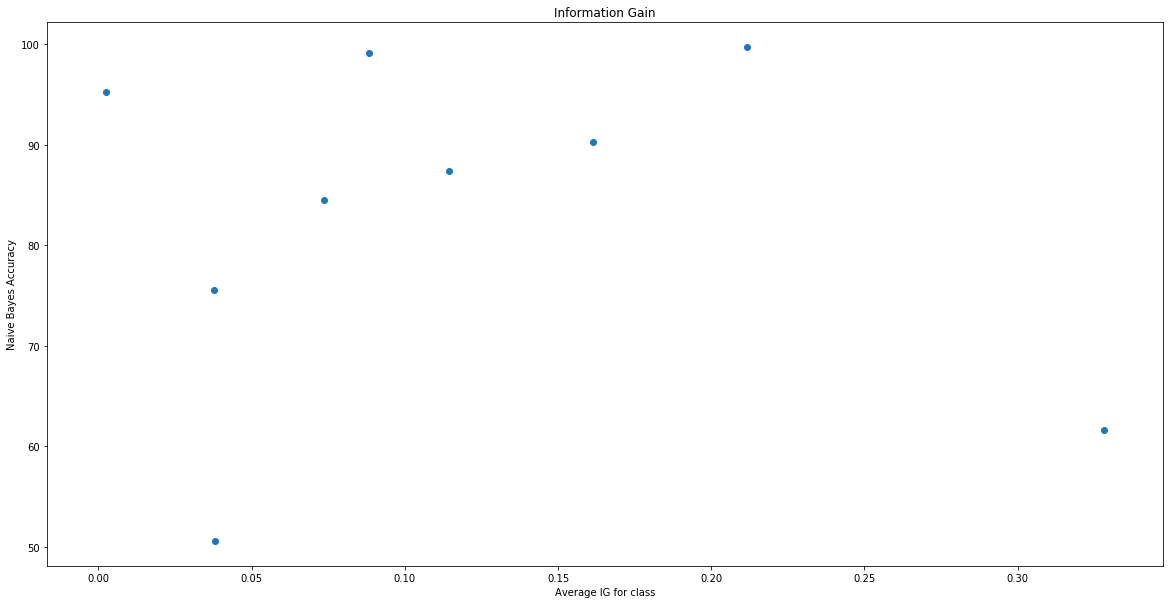

,0,1
0,1.000000,-0.099463
1,-0.099463,1.000000


In [89]:
mapper = defaultdict(list)
for i in avg_ig.keys():
    mapper[i].append(avg_ig[i])
    mapper[i].append(acc[i])
mapper.values()

plt.scatter([i[0] for i in mapper.values()], [i[1] for i in mapper.values()])
plt.title("Information Gain")
plt.xlabel("Average IG for class")
plt.ylabel("Naive Bayes Accuracy")

plt.show()

display(DataFrame.from_dict(mapper).T.corr())

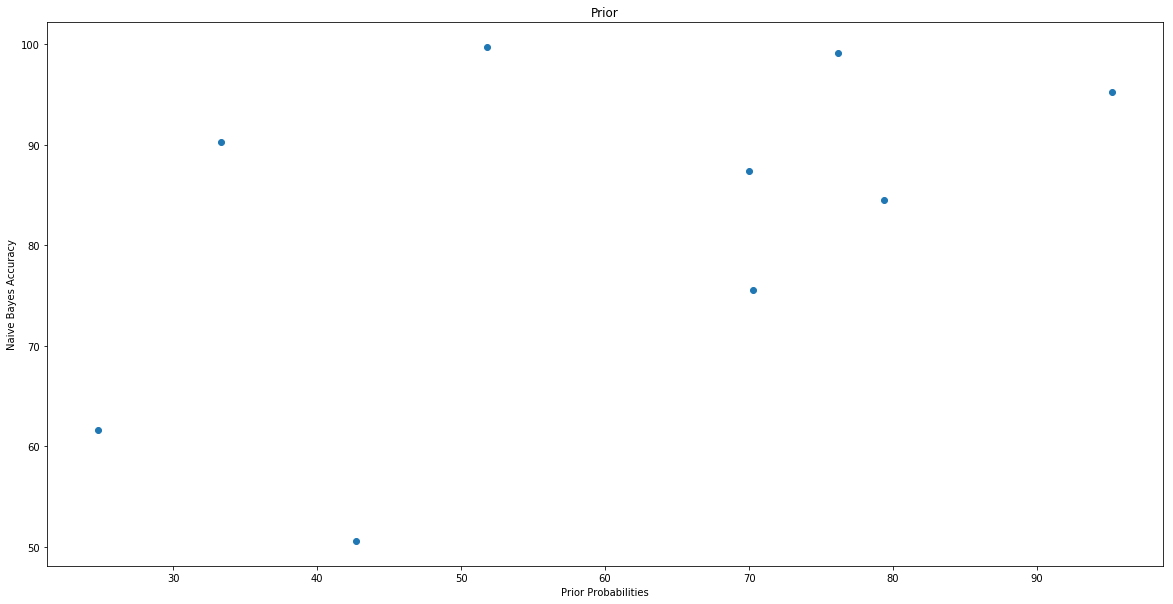

,0,1
0,1.000000,0.521974
1,0.521974,1.000000


In [92]:
priors = list()
for i in datasets:
    df = preprocess(i)
    model =train(df)['priors']
    priors.append(100*model[max(model, key=model.get)])
    
mapper1 = defaultdict(list)
acc = [i[1] for i in mapper.values()]
for i in range(len(datasets)):
    mapper1[i].append(priors[i])
    mapper1[i].append(acc[i])

plt.scatter([i[0] for i in mapper1.values()], [i[1] for i in mapper1.values()])
plt.title("Prior")
plt.xlabel("Prior Probabilities")
plt.ylabel("Naive Bayes Accuracy")

plt.show()

display(DataFrame.from_dict(mapper1).T.corr())

##### Question 2 results

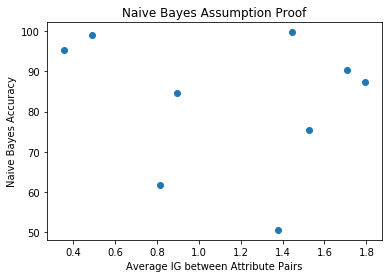

,0,1
0,1.000000,-0.165815
1,-0.165815,1.000000


In [11]:
mapper = defaultdict(list)
for i in ig.keys():
    mapper[i].append(ig[i])
    mapper[i].append(acc[i])
mapper.values()
plt.scatter([i[0] for i in mapper.values()], [i[1] for i in mapper.values()])
plt.title("Naive Bayes Assumption Proof")
plt.xlabel("Average IG between Attribute Pairs")
plt.ylabel("Naive Bayes Accuracy")

plt.show()

display(DataFrame.from_dict(mapper).T.corr())

# Questions 1, 2, 4 and 6 (150 - 200 words for each response):

#### 1. The Naive Bayes classifiers can be seen to vary, in terms of their effectiveness on the given datasets (e.g. in terms of Accuracy). Consider the Information Gain of each attribute, relative to the class distribution — does this help to explain the classifiers’ behaviour? Identify any results that are particularly surprising, and explain why they occur.
In theory, we should expect a higher accuracy if more data is available, since there is more information for the model to use. But in our findings above, we find that the whether Information Gain was low or high did not significantly impact accuracy. 

This can be seen with `primary-tumor.csv` with low performance , compared to `mushroom.csv` where there is one attribute with `0.9` information gain, and the rest between `0.1 - 0.4` and some less than `0.1`. 



##
There are exceptions however, `hypothyroid.csv` whose attributes have very little information gain despite high Naive Bayes classification accuracy. This can be attributed due to the sheer number of `Negative` labels compared to `Hypothyroid` (95.22 to 4.78), where Naive Bayes seems to degenerate to Zero-R because the posterior probabilities are so low that it becomes dependent on the priors.
##

low entropy = low accuracy, high entropy = high accuracy 


Although information gain is quite mininmal between attributes, it could be that the relationship accross 

We noticed that datasets with higher number of instances and attributes performed better (strictly in terms of label prediction accuracy). According to the Information Gain for each attribute given class, we found it to have a `-0.09` correlation which is conventionally considered **weak**.

Due to the nature of Naive Bayes and its assumption on "conditional independence", it multiplies its posteriors with priors. 


    

#### 2. The Information Gain can be seen as a kind of correlation coefficient between a pair of attributes: when the gain is low, the attribute values are uncorrelated; when the gain is high, the attribute values are correlated. In supervised ML, we typically calculate the Infomation Gain between a single attribute and the class, but it can be calculated for any pair of attributes. Using the pair-wise IG as a proxy for attribute interdependence, in which cases are our NB assumptions violated? Describe any evidence (or indeed, lack of evidence) that this is has some effect on the effectiveness of the NB classifier.
In any given dataset, two attributes may depend on each other, but the dependence may be distributed evenly within the attributes. In this case, we can see that the Naive Bayes's assumption of conditional independence is violated. If we just look at two attributes, there may be a strong dependence between them that can affect the classification. However, if you take into account the dependencies when classifying all together, they may cancel each other out and not affect the classification. 

From this, we can argue that it is the distribution of the attribute dependencies, rather than the dependencies between attributes (pair-wise IG) that affect the Naive Bayes Classification (correlation does not imply causation, there may be an underlying distribution). If you look at the graph above, we can also see that across all the datasets, there seems to be no evidence that the Information Gain between attributes plays a role in affecting accuracy. If anything, a look at the correlation table suggests that there is a **W\weak** relationship between pair-wise IG and the performance of our model (in terms of accuracy). 

As such, there is a lack of evidence that it has some effect on the effectiveness of the Naive Bayes classifier.
    

#### 4. Evaluating the model on the same data that we use to train the model is considered to be a major mistake in Machine Learning. Implement a hold–out or cross–validation evaluation strategy. How does your estimate of effectiveness change, compared to testing on the training data? Explain why. (The result might surprise you!)
Implementation: $k$-Fold Cross-Validation
    
In theory, we should expect a higher accuracy if more data is available, since there is more information for the model to use. This means that testing our model on the training data would be the *best case scenario* for accuracy, since our supervised model has seen everything prior to testing. If we take this into account, then our $k$-Fold Cross Validation does a reasonable job (typically a 2% difference or even equal performance in accuracy using $k$ = 10) despite being partitioned.  The reason as to why $k$-Fold Cross Validation seems to perform better than a Hold-Out strategy can be accounted by:
- The *random noise* which $k$-Fold Cross Validation can successfully reduce since it is averaging over the $k$ sets of estimations
- Unlike Hold-Out, where a split of the data is used, the fact that every training instance is eventually used as a testing instance in a partition means that our model is not missing out on any information overall
    

#### 6. Naive Bayes is said to elegantly handle missing attribute values. For the datasets with missing values, is there any evidence that the performance is different on the instances with missing values, compared to the instances where all of the values are present? Does it matter which, or how many values are missing? Would an imputation strategy have any effect on this?
To an extent, it does not matter how many values are missing, but more if the attribute with the missing values has a high information gain or not. This may be since missing values in itself could be significant (i.e. because there is a missing value, it could lead to a specific class label). 

For datasets with missing values, we used a mode (freqeuncy) imputation to fill in missing values since most were categorical - this means that the datasets with more missing values would have their models become slightly more biased.

The graphs and table below suggest that the imputation using mode has little or no impact on evaluation (strictly in terms of label prediction accuracy). There are a total of 5 datasets with missing values; with 2 near identical, 2 with a negative impact and one with a positive impact.
The only positive impact is when testing using the $k$-Fold Cross-Validation method, which may ultimately be due to its ability to reduce random noise, predominantly seen in the `primary-tumour.csv`. The testing on the training data had no impact whatsoever as expected due to the nature of supervised learning algorithms (explained in Q1/2). 

This backs the claim that the Naive Bayes is able to elegantly handle missing attribute values, without the need of imputations. 

##### Question 6 results
Training on test is the exact same with or without imputations

In [66]:
from IPython.display import display
df = read_csv('results.csv').set_index('Unnamed: 0')
display(df)

,Training on Test with Imputation,10-Fold Cross-Validation with Imputation,Training on Test without Imputation,10-Fold Cross-Validation without Imputation
Unnamed: 0,,,,
breast-cancer.csv,75.524476,69.532020,75.524476,70.923645
hepatitis.csv,84.516129,81.375000,84.516129,83.958333
hypothyroid.csv,95.226051,95.226411,95.226051,95.226011
mushroom.csv,99.716888,99.692285,99.716888,99.692300
primary-tumor.csv,61.651917,47.495544,61.651917,45.721925


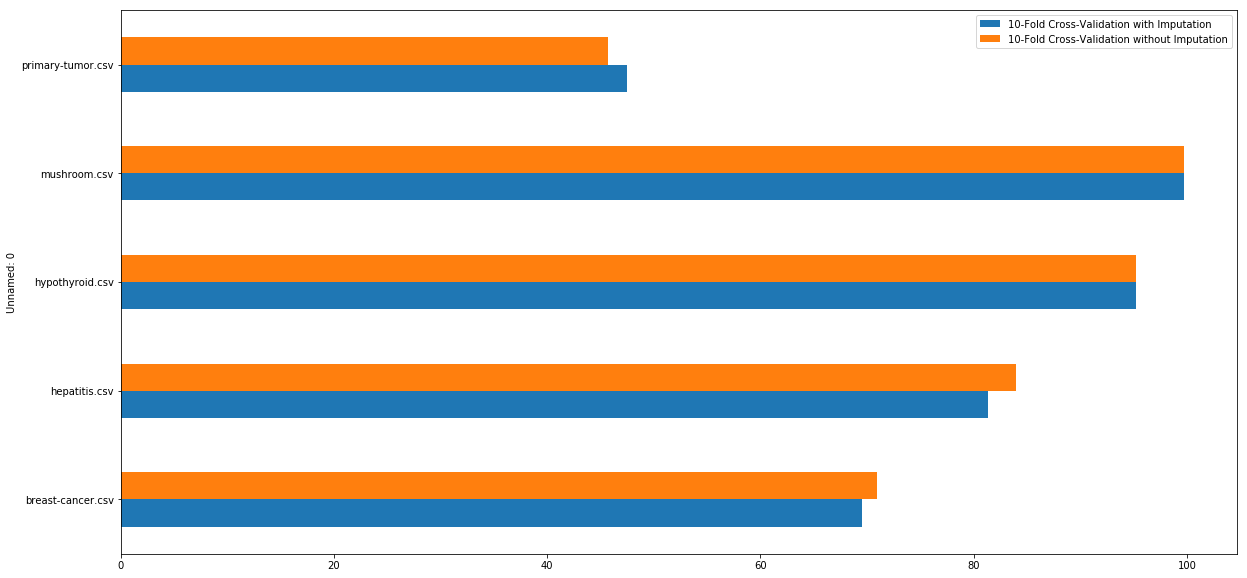

In [69]:
plt.rcParams["figure.figsize"] = (20,10)
df[df.columns[1::2]].plot.barh()
plt.show()